In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
# 데이터
df = pd.read_csv(
    r"C:\ai\lecNote\1st_Project\data\서울_일반음식점_전처리_폐업률머지.csv",
    low_memory=False
)

# 타겟
y = df["폐업률_3년이내_pct"]

# ===============================
# 📌 모델에 넣을 전체 피처 집합
# ===============================
X = df[
    [
        "업태_그룹",
        "구"                 
    ]
]



In [3]:

# ===============================
# 📌 범주형 컬럼 정의
# ===============================
cat_cols = [
    "업태_그룹",
    "구"      
]


# ===============================
# 📌 전처리 파이프라인 정의
# ===============================
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

In [4]:
# ===============================
# 📌 학습 / 테스트 데이터 분리
# ===============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)


In [5]:
from sklearn.ensemble import RandomForestRegressor

rf_model = Pipeline(
        steps=[
        ("preprocess", preprocess),
        ("model", RandomForestRegressor(
            n_estimators=200,   # 트리 개수 (많을수록 안정적)
            max_depth=15,     # 트리 깊이
            random_state=42,   # 재현성
            n_jobs=-1          # CPU 전부 사용 (속도 ↑)
        ))
        ]
)

rf_model.fit(X_train, y_train)



Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['업태_그룹', '구'])])),
                ('model',
                 RandomForestRegressor(max_depth=15, n_estimators=200,
                                       n_jobs=-1, random_state=42))])

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = rf_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"MAE : {mae:.2f}%")
print(f"RMSE: {rmse:.2f}%")




MAE : 0.60%
RMSE: 1.09%


In [7]:
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False


# 🔹 전처리 객체 가져오기
preprocess_fitted = rf_model.named_steps["preprocess"]

# 🔹 OneHotEncoder에서 생성된 컬럼명
cat_features = preprocess_fitted.named_transformers_["cat"] \
    .get_feature_names_out(cat_cols)

# 🔹 최종 전체 피처명
feature_names =  list(cat_features)


In [8]:
# 🔹 RandomForest 모델
rf = rf_model.named_steps["model"]

# 🔹 중요도 DataFrame
importances = pd.DataFrame({
    "feature": feature_names,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

importances.head(10)


,feature,importance
1,업태_그룹_분식/간편식,0.347544
29,구_종로구,0.142453
8,구_강동구,0.078238
27,구_용산구,0.066526
0,업태_그룹_기타,0.055055
30,구_중구,0.032235
7,구_강남구,0.031905
25,구_양천구,0.031291
26,구_영등포구,0.026578
6,업태_그룹_한식,0.026382


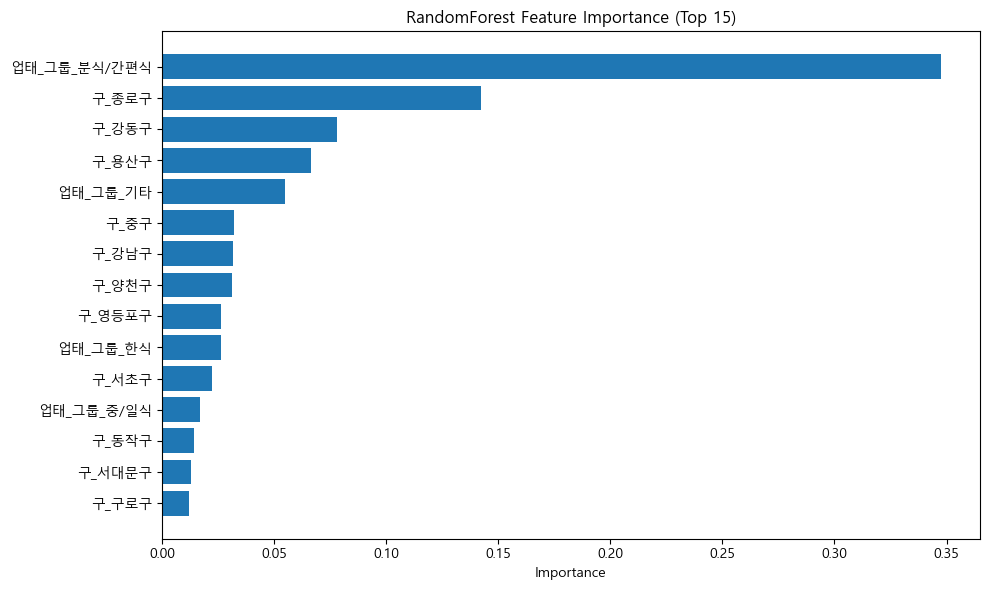

In [9]:
plt.figure(figsize=(10, 6))
plt.barh(
    importances.head(15)["feature"][::-1],
    importances.head(15)["importance"][::-1]
)
plt.title("RandomForest Feature Importance (Top 15)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [10]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [11]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline

xgb_model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", XGBRegressor(
            n_estimators=500,
            max_depth=6,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1
        ))
    ]
)


In [12]:
xgb_model.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['업태_그룹', '구'])])),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.8, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_typ...hts=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=500, n_jobs=-1,
                              num_parallel_tree=None, ...))])

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 🔹 RandomForest
rf_pred = rf_model.predict(X_test)

rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = mean_squared_error(y_test, rf_pred, squared=False)

# 🔹 XGBoost
xgb_pred = xgb_model.predict(X_test)

xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_rmse = mean_squared_error(y_test, xgb_pred, squared=False)

print("📌 RandomForest")
print(f"MAE : {rf_mae:.2f}%")
print(f"RMSE: {rf_rmse:.2f}%")

print("\n📌 XGBoost")
print(f"MAE : {xgb_mae:.2f}%")
print(f"RMSE: {xgb_rmse:.2f}%")


📌 RandomForest
MAE : 0.60%
RMSE: 1.09%

📌 XGBoost
MAE : 0.05%
RMSE: 0.07%


In [14]:
# ===============================
# 📌 RandomForest 예측
# ===============================
rf_pred = rf_model.predict(X_test)

# ===============================
# 📌 XGBoost 예측
# ===============================
xgb_pred = xgb_model.predict(X_test)

# 결과 확인
print("RF 예측값 샘플:", rf_pred[:5])
print("XGB 예측값 샘플:", xgb_pred[:5])


RF 예측값 샘플: [33.30285885 33.30285885 47.5        35.07094927 31.60420283]
XGB 예측값 샘플: [31.21189  33.386524 47.48903  34.897358 29.386597]


In [15]:
# ===============================
# 📌 실제값 vs 예측값 비교
# ===============================
result_df = X_test.copy()

result_df["실제_폐업률"] = y_test
result_df["RF_예측_폐업률"] = rf_pred
result_df["XGB_예측_폐업률"] = xgb_pred

# 🔹 출력용 컬럼 (% 붙인 문자열)
for col in ["실제_폐업률", "RF_예측_폐업률", "XGB_예측_폐업률"]:
    result_df[col + "_표시"] = result_df[col].map(lambda x: f"{x:.2f}%")

result_df.head()


,업태_그룹,구,실제_폐업률,RF_예측_폐업률,XGB_예측_폐업률
72712,한식,성동구,31.20%,33.30%,31.21%
204272,한식,노원구,33.40%,33.30%,33.39%
14142,분식/간편식,양천구,47.50%,47.50%,47.49%
132783,기타,송파구,34.80%,35.07%,34.90%
148751,양식/외식,성동구,29.30%,31.60%,29.39%


In [38]:
# ===============================
# 📌 실제 예측용 입력 데이터 (1건)
# ===============================
new_data = pd.DataFrame([
    {
        "업태_그룹": "분식/간편식",
        "구": "강동구"
    }
])


In [41]:
# ===============================
# 📌 폐업률 예측 (실제 미래 예측)
# ===============================
rf_future_pred = rf_model.predict(new_data)
xgb_future_pred = xgb_model.predict(new_data)


In [42]:
# ===============================
# 📌 예측 결과 테이블
# ===============================
result_pred = new_data.copy()

result_pred["RF_예측_폐업률"] = rf_future_pred
result_pred["XGB_예측_폐업률"] = xgb_future_pred

# 🔹 출력용 컬럼 (% 문자열)
for col in ["RF_예측_폐업률", "XGB_예측_폐업률"]:
    result_pred[col + "_표시"] = result_pred[col].map(lambda x: f"{x:.2f}%")

result_pred.head()


,업태_그룹,구,RF_예측_폐업률,XGB_예측_폐업률,RF_예측_폐업률_표시,XGB_예측_폐업률_표시
0,분식/간편식,강동구,52.0,51.984688,52.00%,51.98%
